# Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


import rnn_code.reberGrammar as rg
import rnn_code.RNN as RNN


%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\appdata\

In [2]:
def print_words(model, n=10, end_count=1):
    start_sequenze = np.asarray([[1., 0., 0., 0., 0., 0., 0.]], dtype=np.float32)
    end_sequenze = np.asarray([[0., 0., 0., 0., 0., 0., 1.]], dtype=np.float32)
    
    f = None
    
    if end_count <=1:
        f = rg.in_grammar
    else:
        f = rg.in_embedded_grammar

    for i in range(n):
        samples = model.sample(start_sequenze, end_sequenze, end_count=end_count)
        word = rg.sequenceToWord(samples[0])
        print("WORD: {} in grammar: {}".format(word, f(word)))


def y_to_softmax(y_data):
    for i, y_seq in enumerate(y_data):
        for j, y in enumerate(y_seq):
            nonzeros = np.count_nonzero(y)
            if nonzeros is not 0:
                y_data[i][j] = np.true_divide(y, nonzeros)

In [3]:
import random
import numpy as np

def num_to_onehot(i):
    res = []
    
    while True:
        v = np.zeros(10)
        j = i % 10
        v[j] = 1
        res.insert(0, v)
        i = i // 10
        
        if i <= 0:
            break
    
    return np.asarray(res)


def get_artificial_data(n=100, min_length=10):
    
    """
    generates sum sequence test date
    x == numbers 0 to 9 onehot
    y == sum of x onehot
    """
    
    if min_length < 1:
        min_length = 1
    
    x = []
    y = []
    
    for i in range(n):
        current_length = random.randint(min_length, (min_length + 1) * 10)
        
        current_sum = 0
        x_example = np.asarray([])
        
        for j in range(current_length):
            num = random.randint(0, 9)
            v = num_to_onehot(num)
            
            current_sum += num
            
            if len(x_example) == 0:
                x_example = v
            else:
                x_example = np.concatenate((x_example, v), axis=0)
        
        
        y_example = num_to_onehot(current_sum)
        
        x.append(x_example)
        y.append(y_example)
    
    
    return np.asarray(x), np.asarray(y)

# "Normale" Beispiele

In [4]:
examples = rg.get_n_unique_examples(100)
examples = rg.pad_examples(examples)
x_train, y_train = rg.split_examples(examples)

print(x_train.shape)

(100, 25, 7)


# Embedded Beispiele

In [5]:
examples_em = rg.get_n_unique_embedded_examples(100)
examples_em = rg.pad_examples(examples_em)
x_train_em, y_train_em = np.asarray(rg.split_examples(examples_em))

print(x_train_em.shape)

(100, 34, 7)


# Sum data

In [6]:
x_sum, y_sum = get_artificial_data(n=100, min_length=5)

# RNN

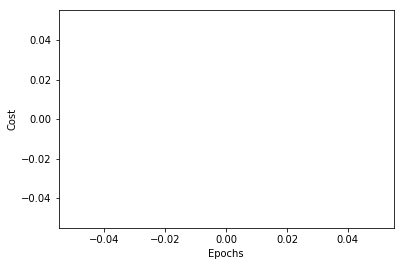

In [109]:
rnn = RNN.RNN(10, 10, 10)
# rnn.train(x_train, y_train, epochs=20, load=True)
rnn.plot()

In [6]:
print_words(rnn)
print("")
    
acc, words = RNN.get_rg_sample_accuracy(rnn, n=5000)
unique_words = set(words)

print("unique words: {}".format(len(unique_words)))

WORD: BTSSXSE in grammar: True
WORD: BPTVVE in grammar: True
WORD: BPVPSE in grammar: True
WORD: BPVPXTVVE in grammar: True
WORD: BPTVPXTVPSE in grammar: True
WORD: BTXSE in grammar: True
WORD: BTXSE in grammar: True
WORD: BPTTVPXTVVE in grammar: True
WORD: BPTTTVPSE in grammar: True
WORD: BPVPXTVPSE in grammar: True

Sample acc: 100.0% over 1000 samples
Sample acc: 100.0% over 2000 samples
Sample acc: 100.0% over 3000 samples
Sample acc: 100.0% over 4000 samples
Sample acc: 100.0% over 5000 samples
Duration: 55.0051851272583sec
unique words: 432


# Attention

In [37]:
# attention = RNN.Attention(learning_rate=0.007)
# attention.train(x_train, y_train, epochs=50, load=True)
# attention.plot()

In [8]:
import keras as k
import keras.layers as kl
import keras.models as km

def attention_keras(input_shape=(None, 7)):
    inputs = kl.Input(shape=input_shape, name="inputs")
    
    rnn1 = kl.GRU(10, return_sequences=True, name="rnn1")(inputs)
    
    # compute importance for each step
    attention = kl.Dense(1, activation='tanh', name="dense")(rnn1) 
    attention = kl.Flatten(name="flatten")(attention)
    attention = kl.Activation('softmax', name="softmax")(attention)
    attention = kl.RepeatVector(10, name="repeat")(attention)
    attention = kl.Permute([2, 1], name="permute")(attention)

    # apply the attention
    sent_representation = kl.Multiply()([rnn1, attention])
    sent_representation = kl.Lambda(lambda xin: k.backend.sum(xin, axis=1))(sent_representation)

    # outputs = kl.Dense(7, activation='softmax')(sent_representation)
    
    rnn2 = k.layers.GRU(10, return_sequences=True, name="rnn2")(sent_representation)
    outputs = kl.TimeDistributed(kl.Dense(7, activation='softmax'))(rnn2)
    
    model = km.Model(input=inputs, output=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["mae"])
    
    print(model.summary())
    
    return model

Using TensorFlow backend.


In [35]:
encoder_inputs = kl.Input(shape=(None, 7))
encoder = kl.GRU(10, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)
encoder_states = [state_h]


decoder_inputs = kl.Input(shape=(None, 7))
decoder_lstm =   kl.GRU(10, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = kl.Dense(7, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = km.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [18]:
# model = attention_keras(input_shape=(1, 7))

In [36]:
# model.fit(x=x_train, y=y_train, batch_size=1, epochs=50)

y_train_right_shift = []

for y in y_train:
    y_train_right_shift.append(np.insert(y[:-1], 0, np.zeros(7), axis=0))
    
y_train_right_shift = np.asarray(y_train_right_shift)

model.fit([x_train, y_train_right_shift], y_train, batch_size=1, epochs=50)

Epoch 1/50
100/100 [==============================] - 7s 73ms/step - loss: 1.4256
Epoch 2/50
100/100 [==============================] - 6s 65ms/step - loss: 1.2893
Epoch 3/50
100/100 [==============================] - 6s 65ms/step - loss: 1.2147
Epoch 4/50
100/100 [==============================] - 6s 64ms/step - loss: 1.1557
Epoch 5/50
100/100 [==============================] - 6s 63ms/step - loss: 1.0976
Epoch 6/50
100/100 [==============================] - 6s 63ms/step - loss: 1.0453
Epoch 7/50
100/100 [==============================] - 6s 65ms/step - loss: 0.9983
Epoch 8/50
100/100 [==============================] - 6s 64ms/step - loss: 0.9579
Epoch 9/50
100/100 [==============================] - 6s 64ms/step - loss: 0.9231
Epoch 10/50
100/100 [==============================] - 6s 63ms/step - loss: 0.8962
Epoch 11/50
100/100 [==============================] - 6s 65ms/step - loss: 0.8763
Epoch 12/50
100/100 [==============================] - 6s 64ms/step - loss: 0.8616
Epoch 13/50
1

In [50]:
prediction = model.predict([np.asarray([x_train[0]]), np.asarray([y_train_right_shift[0]])])

print("y_train:")
print(np.asarray(y_train[0], dtype=np.int32))
print()

print("prediction:")
print(np.asarray(prediction >= 0.3, dtype=np.int32))

y_train:
[[0 1 0 0 1 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

prediction:
[[[0 1 0 0 1 0 0]
  [0 0 0 0 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 1 0 0 1 1 0]
  [0 1 0 0 0 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 1 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 1 1]
  

# Two layers RNN

Epoch:   1 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.5872609538491815 
Epoch:   2 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.585638124495745 
Epoch:   3 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.5845287626143545 
Epoch:   4 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.910434003802948 
Epoch:   5 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.903946670936421 

Model saved! (D:\Fabians Programme\Studium\Master\3. Semester\icw2\rnn_code\../tf_save_rnn2/rnn2.chkp)

Epoch:   6 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.612748259911314 
Epoch:   7 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.59898127312772 
Epoch:   8 /  10 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.589736758032814 
Epoch:   9 /  10 | 10.0% 20.0% 30.0% 4

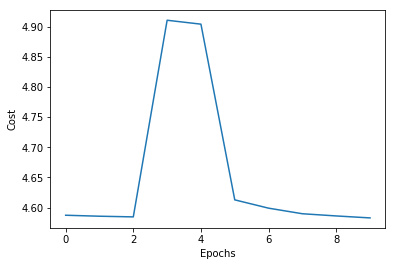

In [27]:
rnn2 = RNN.RNN2(learning_rate=0.007)
rnn2.train(x_train_em, y_train_em, epochs=10, load=True)
rnn2.plot()

In [28]:
print_words(rnn2, end_count=2)
print("")
    
acc, words = RNN.get_rg_sample_accuracy(rnn2, n=2000, end_count=2)
unique_words = set(words)

print("unique words: {}".format(len(unique_words)))

WORD: BTBTXSEXE in grammar: False
WORD: BPBTSXXVVETE in grammar: False
WORD: BTBTSXSETE in grammar: True
WORD: BPBPVPXTTVVEPE in grammar: True
WORD: BTBPVPSEPE in grammar: False
WORD: BTBPVVETE in grammar: True
WORD: BPBPTTVPXTVPSEPE in grammar: True
WORD: BTBTXSESE in grammar: False
WORD: BTBPTVVEPE in grammar: False
WORD: BPBTSXXTVVEPE in grammar: True

Sample acc: 44.3% over 1000 samples
Sample acc: 44.0% over 2000 samples
Duration: 40.129780769348145sec
unique words: 546


# Attention implementations

# Abstract attention 

# Attention class

# AttentionDot class

# Attention paper

# Attention paper bi

# RNN encoder-decoder

# GRU encoder-decoder

In [7]:
from rnn_code import Attention

In [35]:
aiayn = Attention.AttentionIsAllYouNeed(7, 100, 7)

Epoch:  91 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.065573544486514 
Epoch:  92 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.297953696732266 
Epoch:  93 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.096059140419979 
Epoch:  94 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.198990877867304 
Epoch:  95 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.122636352635932 
Epoch:  96 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.133698096675623 
Epoch:  97 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.122853490334132 
Epoch:  98 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.132592391901028 
Epoch:  99 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.087411969059561 
Epoch: 100 / 100 | 10.0% 20.0% 30.0% 

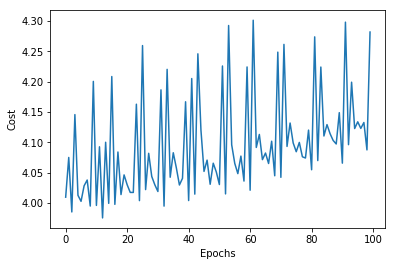

In [37]:
aiayn.train(x_train, y_train, epochs=100)

In [31]:
aiaynwa = Attention.AttentionIsAllYouNeedWithAttetnion(7, 100, 7)

Epoch:  41 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.50241039481343 
Epoch:  42 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.526812223372405 
Epoch:  43 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.22006245806203 
Epoch:  44 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.612990921098689 
Epoch:  45 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.534729707175044 
Epoch:  46 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.568993308744917 
Epoch:  47 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.54199019290383 
Epoch:  48 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.526961319781472 
Epoch:  49 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 10.482433861192382 
Epoch:  50 /  50 | 10.0% 20.0% 

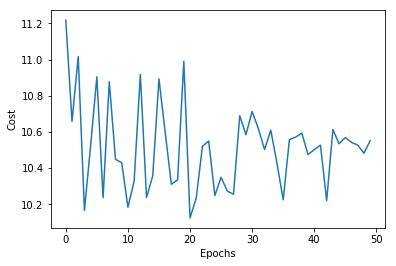

In [39]:
aiaynwa.train(x_train, y_train, epochs=50)

In [46]:
gru = Attention.GRU(7, 10, 7, learning_rate=0.005)

In [48]:
#gru.train(x_train, y_train, epochs=100)

In [79]:
enDeGru = Attention.EnDecoderGRU(7, 10, 7)

Epoch:  91 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.8075827518378658 
Epoch:  92 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.862061996058726 
Epoch:  93 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.856336757903129 
Epoch:  94 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.8786357286492645 
Epoch:  95 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.7938062178029357 
Epoch:  96 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.5087557679031787 
Epoch:  97 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.5199538350545176 
Epoch:  98 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.8013186112379342 
Epoch:  99 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 2.387366159728577 
Epoch: 100 / 100 | 10.0% 20.0% 

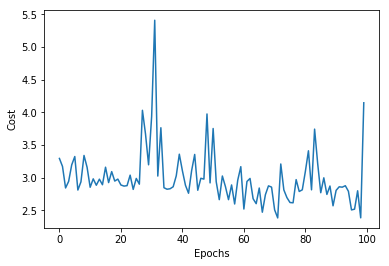

In [85]:
enDeGru.train(x_train, y_train, epochs=100, load=False)

In [61]:
enDeGru.save()

In [84]:
pred = enDeGru.predict(x_train[0], y_train[0], load=False)

pred = np.asarray(pred)

print("y_train:")
print(y_train[0])
print()

print("prediction:")
print(np.asarray(pred >= 0.4, dtype=np.int32))

y_train:
[[0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

prediction:
[[[0 1 0 0 1 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 0 0 1]
  [0 

In [82]:
# enDeGru.load()

for i in range(10):
    sampels = enDeGru.sample(end_count=1, n=1)
    # print(sampels)

    word = rg.sequenceToWord(sampels[0])
    print(word, end=" ")

    print(rg.in_grammar(word))

BTPPE False
BE False
BVE False
BE False
BVE False
BSBVPPVE False
BTBXSPSPPBBE False
BE False
BBTPPE False
BSBE False


In [70]:
enDeGru.save()

# Attention

In [17]:
att = Attention.Attention(7, 10, 7)

In [57]:
y_soft = np.copy(y_train)
y_to_softmax(y_soft)

In [58]:
print(y_train[0][2])
print(y_soft[0][2])

[0. 0. 1. 1. 0. 0. 0.]
[0.  0.  0.5 0.5 0.  0.  0. ]


Epoch:  91 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.551991857577447 
Epoch:  92 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.387328286545466 
Epoch:  93 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.180110769079758 
Epoch:  94 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.136260994420671 
Epoch:  95 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.446120056814481 
Epoch:  96 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.992619536497452 
Epoch:  97 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 5.22003606825435 
Epoch:  98 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.864785726712112 
Epoch:  99 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 4.929668616589125 
Epoch: 100 / 100 | 10.0% 20.0% 30.0% 4

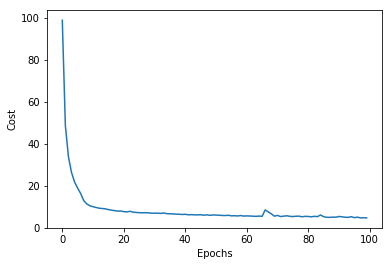

In [18]:
att.train(x_train, y_train, epochs=100, load=False)

In [30]:
# prediction = att.predict(x_train[0], y_soft[0])

# print(y_soft[0])
# print(prediction)

# att.load()

In [25]:
attDot = Attention.AttentionDot(7, 10, 7)

In [22]:
# attDot.train(x_train, y_train, epochs=100)

In [48]:
attentionGRU = Attention.AttentionGRU(7, 10, 7)

Epoch:  91 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.582387999183138 
Epoch:  92 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.4438450474913123 
Epoch:  93 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.4550983393991872 
Epoch:  94 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.6726820668165205 
Epoch:  95 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.5317342436572767 
Epoch:  96 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.5260489427121964 
Epoch:  97 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.3052676226671767 
Epoch:  98 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.600591813418271 
Epoch:  99 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.4519803551723343 
Epoch: 100 / 100 | 10.0% 20.0%

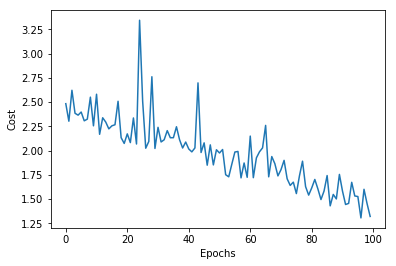

In [50]:
attentionGRU.train(x_train, y_train, epochs=100, load=False)

In [51]:
for i in range(10):
    sampels = attentionGRU.sample(end_count=1, n=1)
    # print(sampels)

    word = rg.sequenceToWord(sampels[0])
    print(word, end=" ")

    print(rg.in_grammar(word))

BPPPPPPSSE False
BPXSPXXPSPPXPPPSPPTTTTPPTPTTTTPTPPTVTPXSXPVPTTVTPE False
BPPPPPPSPPSXXXPXSPPVSSXSPPPTPPXSXPXXSPPVSTPVPXSXPSPPPTVPTPTTTPPPTTPSTPPXPPTTPXPVTPTPSPPVTTPPPVVPTTPXPPVTTTPPVPVTTPXPTVTTPXPTVPPVPTTTXPVPTVTPXXSPTTTTSTTXPVTTPPVPTVTPXPVTPXPTPPPTTTPPTPXXXXSXSSXPPTTPVVTTXPVTTPPTTPPTPSTPXSPTTPPPTPVSPPVTPXSSPTTPPTTSPPTTPPTTPPVPVVTPTTPTPTVPPSTPVTPTPXSXPTTTPSPXPSPPTTTPSTTPPPTTTPXXSSSPTVVPPTVXPTPTPPSXPVPVTTPTPXPSTPVTTTTPPSPTTXPVPTVTSVPTTPVSTSPPTTPPTTXXXXXXSXPSXSXXSPVVTTTXPTPPTPPTPTTPTTTPPTPVXXPSXPXPSXXPSXTTTPPPTTTTPPTVTXXPVVSXE False
BPPSTSVTPTPVPTPVVXSXPXSSPTPE False


KeyboardInterrupt: 

In [38]:
attentionGRU.save()

In [23]:
attGruDot = Attention.AttentionGRUDot(7, 10, 7)

Epoch:  41 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5196207168440475 
Epoch:  42 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.7581080735266204 
Epoch:  43 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5504217035334195 
Epoch:  44 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5639932642392006 
Epoch:  45 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5689185994953865 
Epoch:  46 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5869597061594422 
Epoch:  47 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 1.0186671149710487 
Epoch:  48 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.5618588313775387 
Epoch:  49 /  50 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 0.6273660219003654 
Epoch:  50 /  50 | 10.0% 20.

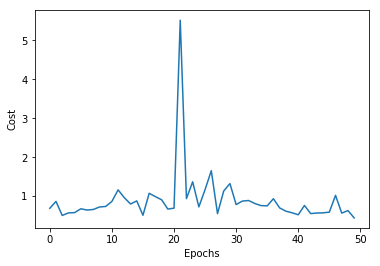

In [27]:
attGruDot.train(x_train, y_train, epochs=50)

In [28]:
attGruDot.save()

In [54]:
gruEnDecoder = EnDecoderGRU(7, 10, 7, learning_rate=0.7)

Epoch:  91 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.234959406636033 
Epoch:  92 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.23240285658278 
Epoch:  93 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.230554799833687 
Epoch:  94 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.228723370709234 
Epoch:  95 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.2265340362355595 
Epoch:  96 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.224463745965663 
Epoch:  97 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.222503061934844 
Epoch:  98 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.2204805641415435 
Epoch:  99 / 100 | 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% | Cost: 7.218476987889702 
Epoch: 100 / 100 | 10.0% 20.0% 30.0%

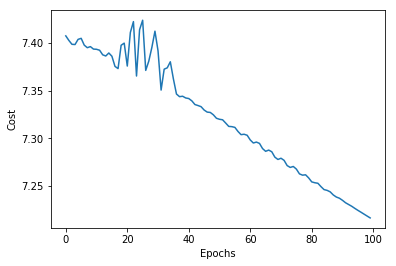

In [78]:
gruEnDecoder.train(x_train, y_train, epochs=100)

In [79]:
gruEnDecoder.save()

In [75]:
attPaperBi = AttentionPaperBi(10, 10, 10)

In [14]:
attPaper.save()

In [307]:
# alpha = att.alpha.eval(session=att.sess)
a = att.sess.run(att.a, feed_dict={att.x: x_train[0], att.y: y_train[0]})

print("x_train[0] shape:")
print(x_train[0].shape)

print("a shape:")
print(a.shape)



W_ia = np.asarray(att.W_ia.eval(session=att.sess), dtype=np.float64)
W_aa = np.asarray(att.W_aa.eval(session=att.sess), dtype=np.float64)
b_a  = np.asarray(att.b_a.eval(session=att.sess), dtype=np.float64)

W_ae = np.asarray(att.W_ae.eval(session=att.sess), dtype=np.float64)
W_he = np.asarray(att.W_he.eval(session=att.sess), dtype=np.float64)
b_e  = np.asarray(att.b_e.eval(session=att.sess), dtype=np.float64)
W_ve = np.asarray(att.W_ve.eval(session=att.sess), dtype=np.float64)

W_Ch = np.asarray(att.W_Ch.eval(session=att.sess), dtype=np.float64)
W_hh = np.asarray(att.W_hh.eval(session=att.sess), dtype=np.float64)
b_h  = np.asarray(att.b_h.eval(session=att.sess), dtype=np.float64)
W_yh = np.asarray(att.W_yh.eval(session=att.sess), dtype=np.float64)

W_ho = np.asarray(att.W_ho.eval(session=att.sess), dtype=np.float64)
b_o  = np.asarray(att.b_o.eval(session=att.sess), dtype=np.float64)


x_train[0] shape:
(30, 7)
a shape:
(30, 7)


In [343]:
import numpy as np

def attention_e(h_tm1, W_he, a, W_ae, W_ve):
    result = np.tanh(np.matmul(np.expand_dims(h_tm1, 0), W_he) +
                     np.matmul(a, W_ae)) # +
                     # self.b_e)

    # result = tf.matmul(result, tf.transpose(tf.expand_dims(self.W_ve, 0)))
    result = np.tanh(np.matmul(result, np.transpose(np.expand_dims(W_ve, 0))))

    return np.reshape(result, result.shape[0])
    
def attention_alpha(e):
    exp_e = np.exp(e)
    return np.true_divide(exp_e, np.sum(exp_e))

def attention_context(alpha, a):
    return np.sum(np.multiply(alpha, a.T).T, 0)

In [331]:
e = attention_e(np.zeros(7), W_he, a, W_ae, W_ve)
alpha = attention_alpha(e)
C = attention_context(alpha, a)

print("    a shape: {}".format(a.shape))
print("    e shape: {}".format(e.shape))
print("alpha shape: {}".format(alpha.shape))
print("    C shape: {}".format(C.shape))
print(C)

    a shape: (30, 7)
    e shape: (30,)
alpha shape: (30,)
    C shape: (7,)
[-0.02259252 -0.15721034 -0.55300143  0.01285371  0.65587081  0.52587422
 -0.31735111]


In [345]:
e = attention_e(np.zeros(7), W_he, a, W_ae, W_ve)
alpha = attention_alpha(e)

print("    a shape: {}".format(a.shape))
print("    e shape: {}".format(e.shape))
print("alpha shape: {}".format(alpha.shape))



C = attention_context(alpha, a)
print("    C shape: {}".format(C.shape))
print(C)


    a shape: (30, 7)
    e shape: (30,)
alpha shape: (30,)
    C shape: (7,)
[-0.02259252 -0.15721034 -0.55300143  0.01285371  0.65587081  0.52587422
 -0.31735111]
[-0.11666059  0.80616932  0.045983   -0.11290994  0.32894125 -0.17032817
 -0.89057359]


In [337]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(3.0)

print(x1.shape)
print(x2.shape)

np.multiply(x1, x2)

(3, 3)
(3,)


array([[ 0.,  1.,  4.],
       [ 0.,  4., 10.],
       [ 0.,  7., 16.]])

# Eager Execution

In [2]:
# https://towardsdatascience.com/simple-neural-network-model-using-tensorflow-eager-execution-997bbadef84a
# https://medium.com/coinmonks/8-things-to-do-differently-in-tensorflows-eager-execution-mode-47cf429aa3ad

import numpy as np

import time

import tensorflow as tf
import tensorflow.contrib.eager as tfe

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.enable_eager_execution(config=config)
tf.executing_eagerly()

True

In [10]:

class EagerGRU():
    
    def __init__(self):
    
        self.n_in=7
        self.n_hid=10
        self.n_out=7
        self.learning_rate=0.005
        self.epsilon=1e-30

        # encoder weights
        self.W_xh = tfe.Variable(tf.truncated_normal(shape=[self.n_in,  self.n_hid], dtype=tf.float64), name="W_xh")
        self.U_hh = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_hid], dtype=tf.float64), name="U_hh")

        self.W_xz = tfe.Variable(tf.truncated_normal(shape=[self.n_in,  self.n_hid], dtype=tf.float64), name="W_xz")
        self.U_hz = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_hid], dtype=tf.float64), name="U_hz")

        self.W_xr = tfe.Variable(tf.truncated_normal(shape=[self.n_in,  self.n_hid], dtype=tf.float64), name="W_xr")
        self.U_hr = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_hid], dtype=tf.float64), name="U_hr")

        self.h_tm1 = tfe.Variable(tf.truncated_normal(shape=[self.n_hid], dtype=tf.float64), name="h_tm1")


        # Output weights
        self.W_ho = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_out], dtype=tf.float64), name="W_ho")


        self.variables = [ self.W_xh, self.U_hh, self.W_xz, self.U_hz, self.W_xr, self.U_hr,
                           self.W_ho ]

    def encoder_cell(self, x):

        mup   = tf.multiply
        mul   = tf.matmul
        sig   = tf.sigmoid
        tanh  = tf.tanh

        out = []
        
        h_t = self.h_tm1

        for x_t in x:

            h_tm1 = tf.expand_dims(h_t, 0)
            x_t = tf.expand_dims(x_t, 0)

            z_t = sig( mul(x_t, self.W_xz) + mul(h_tm1, self.U_hz) )
            r_t = sig( mul(x_t, self.W_xr) + mul(h_tm1, self.U_hr) )

            h_tt = tanh( mul(x_t, self.W_xh) + mul(mup(r_t, h_tm1), self.U_hh) )
            h_t = mup(1 - z_t, h_tm1) + mup(z_t, h_tt)
            
            out_t = sig( mul(h_t, self.W_ho) )

            h_t = tf.reshape(h_t, [h_t.shape[1]])
            out_t = tf.reshape(out_t, [out_t.shape[1]])
            
            out.append(out_t)

        return tf.cast(out, dtype=tf.float64)


    def predict(self, x):
        return self.encoder_cell(x)

    @staticmethod
    def loss(y_pred, y_true, epsilon=1e-30):
        return -tf.reduce_mean(y_true * tf.log(y_pred + epsilon) + (1. - y_true) * tf.log(1. - y_pred + epsilon))


    def train(self, x_train, y_train, epochs=20, learning_rate=0.005):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

        for i in range(epochs):
            
            loss = 0.0

            for x, y in zip(x_train, y_train):

                with tf.GradientTape() as tape:
                    predicted = self.predict(x)
                    current_loss = self.loss(predicted, y)
                    
                    grads = tape.gradient(current_loss, self.variables)
                    optimizer.apply_gradients(zip(grads, self.variables), global_step=tf.train.get_or_create_global_step())

                loss += current_loss

            print("{} / {} Loss: {}".format((i+1), epochs, loss))
        
            
        
            
    

In [17]:

class EagerTest():
    
    def __init__(self, n_in=7, n_hid=10, n_out=7):
    
        self.n_in = n_in
        self.n_hid = n_hid
        self.n_out = n_out
        self.learning_rate=0.005
        self.epsilon=1e-30

        # encoder weights
        self.W_xh = tfe.Variable(tf.truncated_normal(shape=[self.n_in,  self.n_hid], dtype=tf.float64), name="W_xh")
        self.U_hh = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_hid], dtype=tf.float64), name="U_hh")

        self.h_tm1 = tf.zeros(self.n_hid, dtype=tf.float64)
        
        # decoder weights
        self.W_ys = tfe.Variable(tf.truncated_normal(shape=[self.n_in,  self.n_hid], dtype=tf.float64), name="W_ys")
        self.U_ss = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_hid], dtype=tf.float64), name="U_ss")

        # Output weights
        self.W_so = tfe.Variable(tf.truncated_normal(shape=[self.n_hid, self.n_out], dtype=tf.float64), name="W_so")


        self.variables = [ self.W_xh, self.U_hh,
                           self.W_ys, self.U_ss,
                           self.W_so ]

    def encoder_scan(self, _out, x_t):
        mup   = tf.multiply
        mul   = tf.matmul
        sig   = tf.sigmoid
        tanh  = tf.tanh
        relu  = tf.nn.relu
        
        x_t = tf.expand_dims(x_t, 0)
        h_tm1 = tf.expand_dims(_out, 0)

        h_t = tanh( mul(x_t, self.W_xh) + mul(h_tm1, self.U_hh) )

        return tf.reshape(h_t, [h_t.shape[1]])
        
    def encoder_cell(self, x):
        h_tm1 = tf.zeros(self.n_hid, dtype=tf.float64)
        h = tf.scan(self.encoder_scan, x, initializer=(h_tm1))
        
        return h[-1]

    def decoder_scan(self, _out, y_t):
        mup   = tf.multiply
        mul   = tf.matmul
        sig   = tf.sigmoid
        tanh  = tf.tanh
        relu  = tf.nn.relu
        
        s_tm1, out_tm1 = _out

#         if tf.reduce_sum(out_tm1) is not 0.0:
#             i = tf.math.argmax(out_tm1)
#             out_tm1 = tf.one_hot(i, out_tm1.shape[0], dtype=tf.float64)
        
        s_tm1   = tf.expand_dims(s_tm1, 0)
        out_tm1 = tf.expand_dims(out_tm1, 0)
        
        y_t = tf.expand_dims(y_t, 0)

        s_t = tanh( mul(s_tm1, self.U_ss) + mul(y_t, self.W_ys) )
        out_t = sig( mul(s_t, self.W_so) )

        s_t = tf.reshape(s_t, [s_t.shape[1]])
        out_t = tf.reshape(out_t, [out_t.shape[1]])

        return s_t, out_t

    def decoder_cell(self, y):
        s_tm1 = self.h_tm1
        out_tm1 = tf.zeros(self.n_out, dtype=tf.float64)
        
        y = np.insert(y,  0, values=np.zeros(y.shape[1]), axis=0)
        y = np.delete(y, -1, axis=0)
        
        _, out = tf.scan(self.decoder_scan, y, initializer=(s_tm1, out_tm1))            
        
        return out

    def predict(self, x, y):
        self.h_tm1 = self.encoder_cell(x)
        return self.decoder_cell(y)

    @staticmethod
    def loss(y_pred, y_true, epsilon=1e-30):
        return -tf.reduce_mean(y_true * tf.log(y_pred + epsilon) + (1. - y_true) * tf.log(1. - y_pred + epsilon))


    def train(self, x_train, y_train, epochs=20, learning_rate=0.005):
        trainer = tf.train.GradientDescentOptimizer
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        
        
        optimizer = trainer(learning_rate=learning_rate)
        length = len(x_train)
        
        for i in range(epochs):
            print("Epoch {:3} / {:3}: ".format((i+1), epochs), end="")
            
            loss = 0.0
            
            j = 1
            for x, y in zip(x_train, y_train):

                with tf.GradientTape() as tape:
                    predicted = self.predict(x, y)
                    current_loss = self.loss(predicted, y)
                    
                    grads = tape.gradient(current_loss, self.variables)
                    
                    # for i, _ in enumerate(grads):
                    #     grads[i] *= -1
                    
                    optimizer.apply_gradients(zip(grads, self.variables), global_step=tf.train.get_or_create_global_step())
                
                if j % (length // 10) == 0:
                    print("{}% ".format(j / length * 100), end="")
                
                loss += current_loss
                j += 1
            
            print("Loss: {}".format(loss))

In [18]:
eager = EagerTest()

In [20]:
eager.train(x_train, y_train, epochs=100, learning_rate=0.5)

Epoch   1 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.14892024122488
Epoch   2 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.14548398808024
Epoch   3 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.14205293505852
Epoch   4 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.13861958869357
Epoch   5 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.135175677354828
Epoch   6 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.131711426069684
Epoch   7 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.128214385811676
Epoch   8 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.1246677863111
Epoch   9 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% Loss: 10.121048720852565
Epoch  10 / 100: 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% L

KeyboardInterrupt: 

In [11]:
eagerGRU = EagerGRU()
eagerGRU.train(x_train, y_train, epochs=50, learning_rate=0.7)

1 / 50 Loss: 53.28703387612886
2 / 50 Loss: 19.615178109712772
3 / 50 Loss: 10.560224819148472
4 / 50 Loss: 6.845991698058424
5 / 50 Loss: 5.0425538437367345
6 / 50 Loss: 3.932359487663367
7 / 50 Loss: 3.170400249513329
8 / 50 Loss: 2.6207313557608938
9 / 50 Loss: 2.216480432649298
10 / 50 Loss: 1.9141184403510356
11 / 50 Loss: 1.6811157042576848
12 / 50 Loss: 1.4959213562667817
13 / 50 Loss: 1.3452740912649919
14 / 50 Loss: 1.2206343362093055
15 / 50 Loss: 1.1160978460966442
16 / 50 Loss: 1.0273639968622814
17 / 50 Loss: 0.9512028011350138
18 / 50 Loss: 0.8851491902273679
19 / 50 Loss: 0.8273049923999963
20 / 50 Loss: 0.7761988049975087
21 / 50 Loss: 0.730682490284262
22 / 50 Loss: 0.689853359384493
23 / 50 Loss: 0.6529952339439788
24 / 50 Loss: 0.6195337708315625
25 / 50 Loss: 0.5890027977132151
26 / 50 Loss: 0.5610191991099828
27 / 50 Loss: 0.5352643209370744
28 / 50 Loss: 0.5114701732889707
29 / 50 Loss: 0.4894090586434715
30 / 50 Loss: 0.46888563486176094
31 / 50 Loss: 0.449730768

In [36]:
import numpy as np

In [55]:
mat1 = np.ones([5, 10])

vec = np.arange(1, 11)

print(mat1.shape)
print(vec.shape)

res = np.tensordot(mat1, vec, axes=1)

print(res)
print(res.shape)

(5, 10)
(10,)
[55. 55. 55. 55. 55.]
(5,)
